<a href="https://colab.research.google.com/github/firmansyahr/Customer-Segmentation-Loyalty-Analytics/blob/main/Notebook/3_DBSCAN_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA

In [ ]:
file_path = '/content/drive/My Drive/ITS/Semester 4/Analytic Project/Tugas Clustering Final Project/Transaksi Regional 3, 4, dan 5 2024.xlsx'
# Read the Excel file
df = pd.read_excel(file_path)

# Display the first few rows
df.head()

,Tanggal,ID Toko,Nama Toko,Cluster,Regional,Area Toko,Kabupaten Toko,Total Ton,Total Poin,Total Reward
0,Februari 2024,100121021,UD Widiastuti Simanjuntak,SUPER PLATINUM,3,AREA 33,KOTA TANGERANG SELATAN,164.05,164,1025313
1,Februari 2024,100164612,UD Tampubolon,GOLD,3,AREA 33,KABUPATEN TANGERANG,79.4,79,397000
2,Februari 2024,100165231,UD Widiastuti Simanjuntak,PLATINUM,3,AREA 33,KABUPATEN TANGERANG,256,256,1600000
3,Februari 2024,100051536,UD Tampubolon,GOLD,3,AREA 33,KOTA TANGERANG,88.4,88,442000
4,Februari 2024,100023720,UD Ramadan Nababan,PLATINUM,3,AREA 33,KABUPATEN TANGERANG,240.3,240,1501875


In [ ]:
df['Total Ton'] = pd.to_numeric(df['Total Ton'].astype(str).str.replace(',', '.'), errors='coerce')
df['Total Poin'] = pd.to_numeric(df['Total Poin'].astype(str).str.replace(',', '.'), errors='coerce')
df['Total Reward'] = df['Total Reward'].astype(str).str.replace('Rp', '', regex=False).str.replace('.', '', regex=False).str.strip()
df['Total Reward'] = pd.to_numeric(df['Total Reward'], errors='coerce')

df.dropna(subset=['Total Ton', 'Total Poin', 'Total Reward'], inplace=True)

In [ ]:
agg = df.groupby('ID Toko').agg({
    'Total Ton': 'sum',
    'Total Poin': 'sum',
    'Total Reward': 'sum',
    'Regional': 'first',
    'Cluster': 'first'
}).reset_index()


In [ ]:
agg['Poin_Extra'] = agg['Total Poin'] - agg['Total Ton']
agg['Reward_per_Poin'] = agg['Total Reward'] / agg['Total Poin']

agg.replace([np.inf, -np.inf], np.nan, inplace=True)
agg.dropna(subset=['Poin_Extra', 'Reward_per_Poin'], inplace=True)

print("\nContoh ringkasan per toko:")
print(agg.head())

# Print the number of remaining rows after cleaning
print(f"\nNumber of remaining data points after cleaning: {len(agg)}")

# Optional: Print shape (rows, columns) of the DataFrame
print(f"Shape of the DataFrame: {agg.shape}")


Contoh ringkasan per toko:
     ID Toko  Total Ton  Total Poin  Total Reward  Regional         Cluster  \
0  100000091     849.00      881.00     4405000.0         5            Gold   
1  100000106    1472.26     1877.16     9383300.0         5          Bronze   
2  100000108    1850.00     2108.00    10540000.0         5          Bronze   
3  100000109    1906.72     2104.72    10523600.0         5          Silver   
4  100000110    1547.88     1843.88     9219400.0         5  Super Platinum   

   Poin_Extra  Reward_per_Poin  
0        32.0      5000.000000  
1       404.9      4998.668201  
2       258.0      5000.000000  
3       198.0      5000.000000  
4       296.0      5000.000000  

Number of remaining data points after cleaning: 1255
Shape of the DataFrame: (1255, 8)


In [ ]:
agg['Regional'] = agg['Regional'].astype(str)

In [ ]:
encoder = OneHotEncoder(
    sparse_output=False,
    drop='first',
    categories=[['3', '4', '5']]
)
region_encoded = encoder.fit_transform(agg[['Regional']])
region_df = pd.DataFrame(region_encoded, columns=encoder.get_feature_names_out(['Regional']))

print("\nDummy Regional yang dibuat:")
print(region_df.head())
# Optional: Print shape (rows, columns) of the DataFrame
print(f"Shape of the DataFrame: {region_df.shape}")


Dummy Regional yang dibuat:
   Regional_4  Regional_5
0         0.0         1.0
1         0.0         1.0
2         0.0         1.0
3         0.0         1.0
4         0.0         1.0
Shape of the DataFrame: (1255, 2)


In [ ]:
agg_encoded = pd.concat([agg.reset_index(drop=True), region_df.reset_index(drop=True)], axis=1)
print(f"Shape of the DataFrame: {agg_encoded.shape}")

Shape of the DataFrame: (1255, 10)


In [ ]:
# 3. Select Relevant Columns
features = ['Total Ton', 'Poin_Extra'] + list(region_df.columns)
print("\nFitur yang digunakan untuk clustering:")
print(features)

X = agg_encoded[features]
print(f"Shape of the DataFrame: {X.shape}")


Fitur yang digunakan untuk clustering:
['Total Ton', 'Poin_Extra', 'Regional_4', 'Regional_5']
Shape of the DataFrame: (1255, 4)


In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

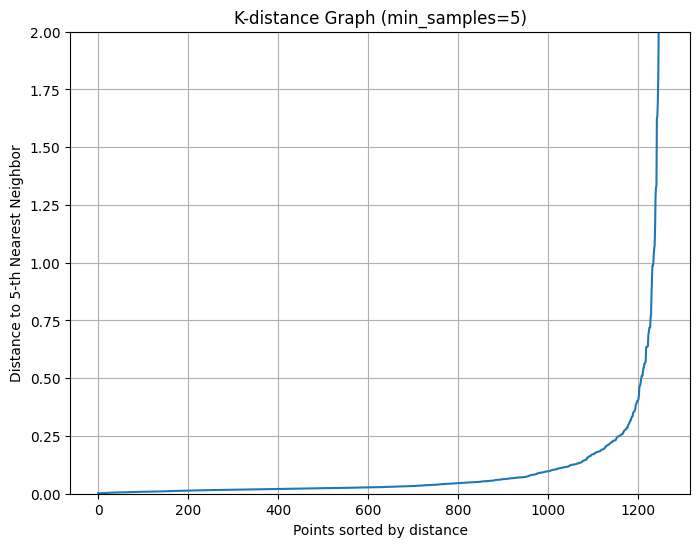

In [ ]:
# Define min_samples (number of nearest neighbors)
min_samples = 5  # Or adjust this based on your dataset

from sklearn.neighbors import NearestNeighbors
# Fit NearestNeighbors model to your data (X_scaled is the scaled feature matrix)
neighbors = NearestNeighbors(n_neighbors=min_samples)
neighbors_fit = neighbors.fit(X_scaled)  # Assuming X_scaled is the data you are using
distances, indices = neighbors_fit.kneighbors(X_scaled)

# Sort the distances to get the k-distance
distances = np.sort(distances[:, -1])  # The distance to the 5th nearest neighbor (k=5)
plt.figure(figsize=(8, 6))
plt.plot(distances)
plt.title(f'K-distance Graph (min_samples={min_samples})')
plt.xlabel('Points sorted by distance')
plt.ylabel(f'Distance to {min_samples}-th Nearest Neighbor')

# Adjusting Y-axis limits to zoom in on the elbow range
plt.ylim(0, 2)  # Adjust this range based on where the elbow is visible
plt.grid(True)
plt.show()

In [ ]:
# Define the range for eps and min_samples
eps_values = np.arange(0.5, 1.5, 0.05)  # Try values between 0.5 and 1.0
min_samples_values = [3, 4, 5, 6, 7, 8, 9, 10]  # Common values for min_samples

# Store results
results = []

# Grid search over eps and min_samples
for eps in eps_values:
    for min_samples in min_samples_values:
        db = DBSCAN(eps=eps, min_samples=min_samples)
        labels = db.fit_predict(X_scaled)  # Assuming X_scaled is your feature matrix (scaled)

        # Get the number of clusters and noise points
        unique_labels = set(labels)
        num_noise = (labels == -1).sum()  # Noise points
        num_clusters = len(unique_labels) - (1 if -1 in unique_labels else 0)

        print(f"eps={eps}, min_samples={min_samples} => Clusters: {num_clusters}, Noise: {num_noise}")

        if num_clusters > 1:
            sil_score = silhouette_score(X_scaled, labels)
        else:
            sil_score = -1  # If only noise or 1 cluster, set silhouette score to -1

        results.append((eps, min_samples, sil_score))

# Convert results to DataFrame for easy inspection
df_results = pd.DataFrame(results, columns=['eps', 'min_samples', 'silhouette'])
df_results = df_results[df_results['silhouette'] != -1]  # Remove invalid results (silhouette = -1)

# Sort by silhouette score (highest first) and number of clusters (fewer clusters are better)
df_results_sorted = df_results.sort_values(by=['silhouette', 'eps', 'min_samples'], ascending=[False, True, True])

# Display the best configurations
print("Best configurations with highest Silhouette Score:")
print(df_results_sorted.head())

eps=0.5, min_samples=3 => Clusters: 5, Noise: 24
eps=0.5, min_samples=4 => Clusters: 4, Noise: 29
eps=0.5, min_samples=5 => Clusters: 3, Noise: 36
eps=0.5, min_samples=6 => Clusters: 3, Noise: 36
eps=0.5, min_samples=7 => Clusters: 4, Noise: 38
eps=0.5, min_samples=8 => Clusters: 3, Noise: 44
eps=0.5, min_samples=9 => Clusters: 3, Noise: 46
eps=0.5, min_samples=10 => Clusters: 3, Noise: 47
eps=0.55, min_samples=3 => Clusters: 5, Noise: 22
eps=0.55, min_samples=4 => Clusters: 4, Noise: 27
eps=0.55, min_samples=5 => Clusters: 4, Noise: 30
eps=0.55, min_samples=6 => Clusters: 3, Noise: 35
eps=0.55, min_samples=7 => Clusters: 3, Noise: 35
eps=0.55, min_samples=8 => Clusters: 3, Noise: 37
eps=0.55, min_samples=9 => Clusters: 3, Noise: 42
eps=0.55, min_samples=10 => Clusters: 3, Noise: 43
eps=0.6000000000000001, min_samples=3 => Clusters: 5, Noise: 22
eps=0.6000000000000001, min_samples=4 => Clusters: 4, Noise: 26
eps=0.6000000000000001, min_samples=5 => Clusters: 4, Noise: 26
eps=0.60000000

In [ ]:
# Define the range for eps and min_samples
eps_values = np.arange(0.5, 1.5, 0.05)  # Try values between 0.5 and 1.0
min_samples_values = [3, 4, 5, 6, 7, 8, 9, 10]  # Common values for min_samples

# Store results
results = []

# Grid search over eps and min_samples
for eps in eps_values:
    for min_samples in min_samples_values:
        db = DBSCAN(eps=eps, min_samples=min_samples)
        labels = db.fit_predict(X_scaled)  # Assuming X_scaled is your feature matrix (scaled)

        # Get the number of clusters and noise points
        unique_labels = set(labels)
        num_noise = (labels == -1).sum()  # Noise points
        num_clusters = len(unique_labels) - (1 if -1 in unique_labels else 0)

        print(f"eps={eps}, min_samples={min_samples} => Clusters: {num_clusters}, Noise: {num_noise}")

        # Check if the number of clusters is 4 (excluding noise) or 5 (total clusters, including noise)
        if num_clusters == 4 or num_clusters + num_noise == 5:
            if num_clusters > 1:  # Valid cluster count (must be more than 1 cluster)
                sil_score = silhouette_score(X_scaled, labels)
            else:
                sil_score = -1  # If only noise or 1 cluster, set silhouette score to -1
        else:
            sil_score = -1  # Exclude configurations where clusters are not 4 or 5

        # Append valid results to the list
        if sil_score != -1:
            results.append((eps, min_samples, sil_score))

# Convert results to DataFrame for easy inspection
df_results = pd.DataFrame(results, columns=['eps', 'min_samples', 'silhouette'])

# Sort by silhouette score (highest first) and number of clusters (fewer clusters are better)
df_results_sorted = df_results.sort_values(by=['silhouette', 'eps', 'min_samples'], ascending=[False, True, True])

# Display the best configurations
print("Best configurations with highest Silhouette Score:")
print(df_results_sorted.head())


eps=0.5, min_samples=3 => Clusters: 5, Noise: 24
eps=0.5, min_samples=4 => Clusters: 4, Noise: 29
eps=0.5, min_samples=5 => Clusters: 3, Noise: 36
eps=0.5, min_samples=6 => Clusters: 3, Noise: 36
eps=0.5, min_samples=7 => Clusters: 4, Noise: 38
eps=0.5, min_samples=8 => Clusters: 3, Noise: 44
eps=0.5, min_samples=9 => Clusters: 3, Noise: 46
eps=0.5, min_samples=10 => Clusters: 3, Noise: 47
eps=0.55, min_samples=3 => Clusters: 5, Noise: 22
eps=0.55, min_samples=4 => Clusters: 4, Noise: 27
eps=0.55, min_samples=5 => Clusters: 4, Noise: 30
eps=0.55, min_samples=6 => Clusters: 3, Noise: 35
eps=0.55, min_samples=7 => Clusters: 3, Noise: 35
eps=0.55, min_samples=8 => Clusters: 3, Noise: 37
eps=0.55, min_samples=9 => Clusters: 3, Noise: 42
eps=0.55, min_samples=10 => Clusters: 3, Noise: 43
eps=0.6000000000000001, min_samples=3 => Clusters: 5, Noise: 22
eps=0.6000000000000001, min_samples=4 => Clusters: 4, Noise: 26
eps=0.6000000000000001, min_samples=5 => Clusters: 4, Noise: 26
eps=0.60000000

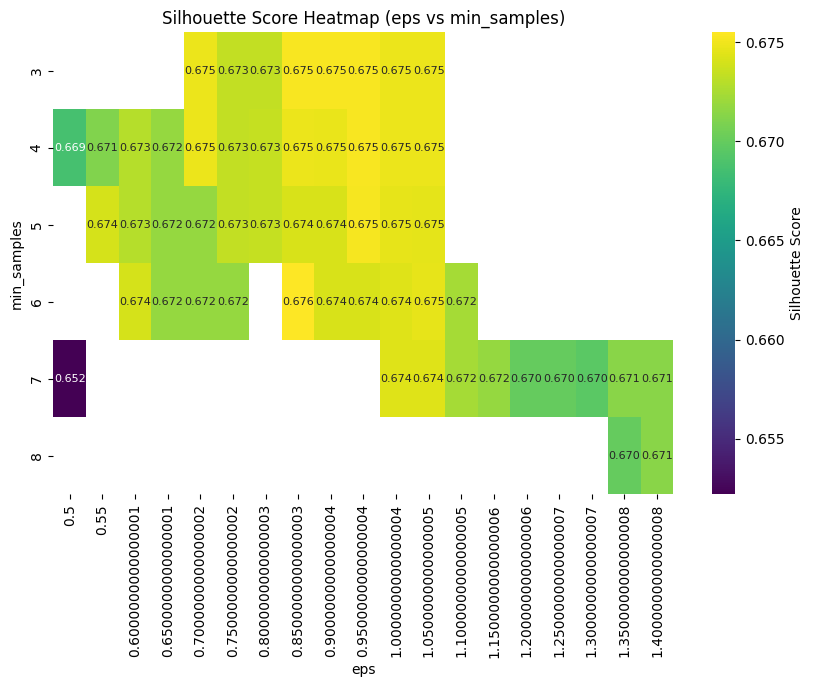

In [ ]:
# Create a pivot table to organize the data for plotting
df_pivot = df_results_sorted.pivot(index='min_samples', columns='eps', values='silhouette')

# Plot the heatmap to visualize Silhouette Scores
plt.figure(figsize=(10, 6))
sns.heatmap(df_pivot, annot=True, cmap="viridis", fmt='.3f', cbar_kws={'label': 'Silhouette Score'},
            annot_kws={"size": 8},  # Adjust font size of the annotations
            xticklabels=df_pivot.columns, yticklabels=df_pivot.index,  # Use current labels
            cbar=True)
plt.title('Silhouette Score Heatmap (eps vs min_samples)')
plt.xlabel('eps')
plt.ylabel('min_samples')
plt.show()

In [ ]:
# Apply DBSCAN using the best configuration: eps=0.55, min_samples=8
db = DBSCAN(eps=0.85, min_samples=6)
labels = db.fit_predict(X_scaled)  # Assuming X_scaled is your feature matrix (scaled)

# Add the cluster labels to the DataFrame
agg_encoded['Cluster'] = labels  # Add labels to your original data frame

# Print the number of clusters and noise points
num_clusters = len(set(labels)) - (1 if -1 in labels else 0)
num_noise = (labels == -1).sum()
print(f"Number of clusters (excluding noise): {num_clusters}")
print(f"Number of noise points: {num_noise}")

Number of clusters (excluding noise): 4
Number of noise points: 18


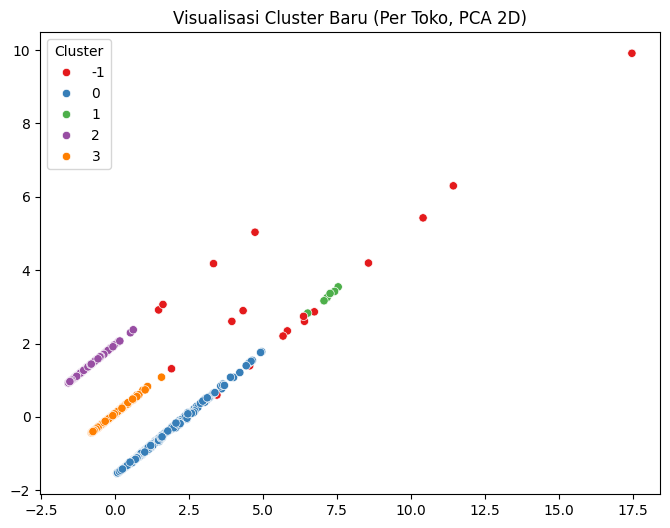

In [ ]:
# Apply PCA to reduce to 2D for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=agg_encoded['Cluster'], palette='Set1')
plt.title('Visualisasi Cluster Baru (Per Toko, PCA 2D)')
plt.show()

In [ ]:
# Group by the 'Cluster' column and calculate statistics
cluster_summary = agg_encoded.groupby('Cluster').agg({
    'Total Ton': 'mean',        # Mean of Total Ton
    'Poin_Extra': 'mean',       # Mean of Poin_Extra
    'Regional': lambda x: x.mode()[0],  # Mode of the 'Regional' column (most frequent value)
}).reset_index()

# Display the cluster summary table
print(cluster_summary)


   Cluster     Total Ton    Poin_Extra Regional
0       -1  18040.116111  13341.706111        5
1        0   2699.735041   1485.334431        5
2        1  16806.140000  17322.253333        5
3        2   1033.816856    683.169227        4
4        3   1376.681083    833.546154        3


In [ ]:
# Calculate the Silhouette Score
sil_score = silhouette_score(X_scaled, labels)

# Display the final Silhouette Score
print(f"Final Silhouette Score: {sil_score}")

Final Silhouette Score: 0.6755046060314059


In [ ]:
# Assuming `agg_encoded` contains the original data and `labels` contains the cluster labels from DBSCAN

# Add the cluster labels to the DataFrame
agg_encoded['Cluster'] = labels  # Add the cluster labels to the dataframe

# Show the final table in Google Colab
# Display a preview of the results (only a subset for readability)
import google.colab.data_table as dt

# Display the table with the cluster labels
dt.DataTable(agg_encoded)  # This will show the DataFrame in a readable format within Google Colab

# Show the first few rows for preview
agg_encoded.head()

,ID Toko,Total Ton,Total Poin,Total Reward,Regional,Cluster,Poin_Extra,Reward_per_Poin,Regional_4,Regional_5
0,100000091,849.00,881.00,4405000.0,5,0,32.0,5000.000000,0.0,1.0
1,100000106,1472.26,1877.16,9383300.0,5,0,404.9,4998.668201,0.0,1.0
2,100000108,1850.00,2108.00,10540000.0,5,0,258.0,5000.000000,0.0,1.0
3,100000109,1906.72,2104.72,10523600.0,5,0,198.0,5000.000000,0.0,1.0
4,100000110,1547.88,1843.88,9219400.0,5,0,296.0,5000.000000,0.0,1.0


/tmp/ipython-input-22-2567492720.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=agg_encoded, x='Cluster', y='Total Ton', ax=axes[1], palette="Set3")
/tmp/ipython-input-22-2567492720.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=agg_encoded, x='Cluster', y='Poin_Extra', ax=axes, palette="Set2")


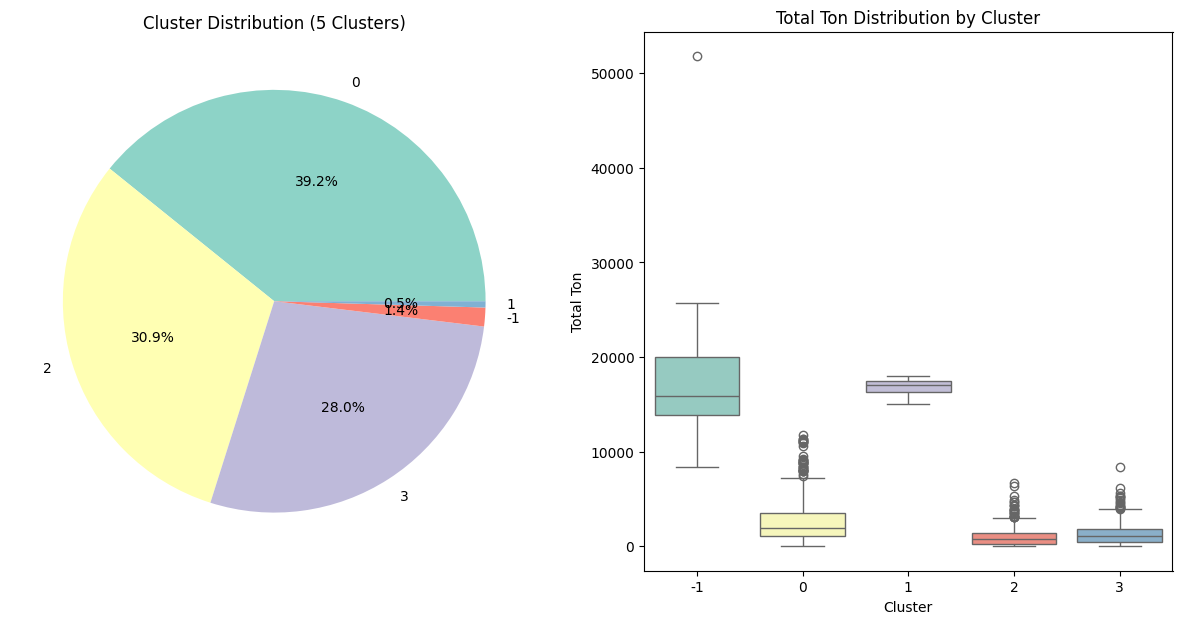

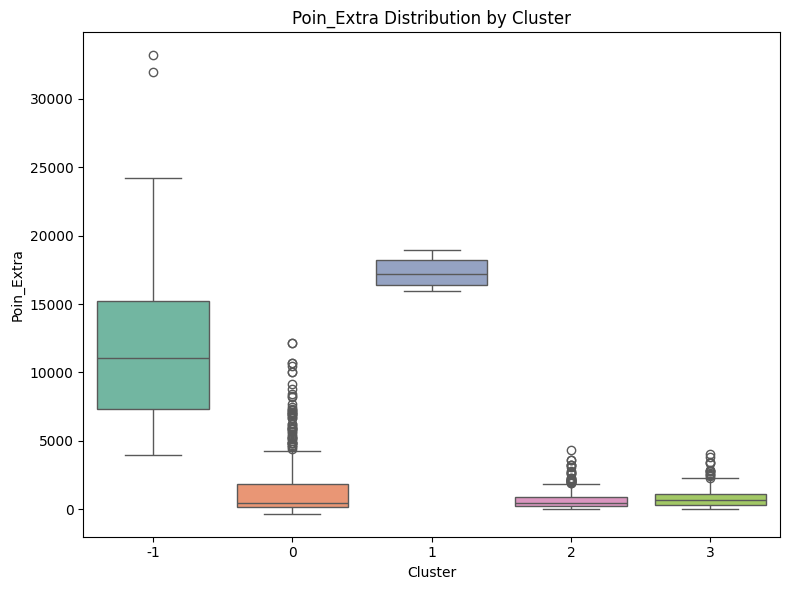

In [ ]:
# Set up the figure with two subplots (pie chart and separate box plots)
fig, axes = plt.subplots(1, 2, figsize=(15, 7))

# 1. Pie Chart: Cluster distribution
cluster_counts = agg_encoded['Cluster'].value_counts()
axes[0].pie(cluster_counts, labels=cluster_counts.index, autopct='%1.1f%%', colors=sns.color_palette("Set3", len(cluster_counts)))
axes[0].set_title(f'Cluster Distribution ({len(cluster_counts)} Clusters)')

# 2. Box Plot: Total Ton distribution by cluster
sns.boxplot(data=agg_encoded, x='Cluster', y='Total Ton', ax=axes[1], palette="Set3")
axes[1].set_title('Total Ton Distribution by Cluster')
axes[1].set_ylabel('Total Ton')
axes[1].set_xlabel('Cluster')

# Create a second plot for Poin_Extra on the right side (same axes, next to the first)
fig, axes = plt.subplots(figsize=(8, 6))
sns.boxplot(data=agg_encoded, x='Cluster', y='Poin_Extra', ax=axes, palette="Set2")
axes.set_title('Poin_Extra Distribution by Cluster')
axes.set_ylabel('Poin_Extra')
axes.set_xlabel('Cluster')

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
# Save the clustering results to a CSV file
agg_encoded.to_csv('final_clustering_results.csv', index=False)

# Inform the user that the file has been saved
print("Clustering results saved as 'final_clustering_results.csv'")

Clustering results saved as 'final_clustering_results.csv'


In [ ]:
from google.colab import files
files.download('final_clustering_results.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>